In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets
import os


In [2]:
IMAGE_SIZE = 32
Z_DIM = 128
EPOCH = 5

In [3]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()

In [4]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [5]:
def preprocess(imgs):
    imgs = imgs.astype("float32")/255
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs
    
train = preprocess(x_train)[:100]
test = preprocess(x_test)

print(train.shape)
print(train.shape)

(100, 32, 32, 1)
(100, 32, 32, 1)


In [6]:
from tensorflow.keras import layers,models,losses,metrics,optimizers,callbacks

# Discriminator

In [7]:
discrminator_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1),name="discriminator_input")

x = layers.Conv2D(64,kernel_size=(3,3),strides=2,padding="same")(discrminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(128,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(256,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(1,kernel_size=(4,4),strides=1,padding="valid",use_bias=False,activation="sigmoid")(x)
discrminator_output = layers.Flatten(name="discrminator_output")(x)

discrminator = models.Model(discrminator_input,discrminator_output)
discrminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 32, 32, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization (Batch  (None, 8, 8, 128)         512       
 Normalization)                                              

# Generator 

In [8]:
generator_input = layers.Input(shape=(Z_DIM,))

x = layers.Dense(2*2*16)(generator_input)
x = layers.Reshape((2,2,16))(x)

x = layers.Conv2DTranspose(8,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(16,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(32,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

generator_output = layers.Conv2D(1,kernel_size=3,strides=1,padding="same",activation="sigmoid")(x)

generator = models.Model(generator_input,generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 reshape (Reshape)           (None, 2, 2, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 8)           1160      
 anspose)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 8)           32        
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 8)           0   

# GAN

In [9]:
class DCGAN(models.Model):
    def __init__(self,my_discriminator,my_generator,z_dim=Z_DIM):
        super(DCGAN,self).__init__()
        
        self.discriminator = my_discriminator
        self.generator = my_generator
        self.z_dim = z_dim
        self.discriminator_opt = None
        self.generator_opt = None
        self.loss_fn = None
        self.g_loss = None
        self.d_loss = None
        
    def call(self, inputs, training=None, mask=None):
        # This method should handle both real and generated images
        return self.discriminator(inputs)
    
    def compile(self,d_opt,g_opt,loss_fn):
        super(DCGAN,self).compile()
        self.discriminator_opt = d_opt
        self.generator_opt = g_opt
        self.loss_fn = loss_fn
        self.discriminator.compile(optimizer=self.discriminator_opt,loss=self.loss_fn)
        self.generator.compile(optimizer=self.generator_opt,loss=self.loss_fn)
        self.d_loss = metrics.Mean(name="d_loss")
        self.g_loss = metrics.Mean(name="g_loss")
        
        
    @property
    def metrics(self):
        return [self.d_loss,self.g_loss]
    
    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        sample_vector = tf.random.normal(shape=(batch_size, self.z_dim))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(sample_vector)
            concat_imgs = tf.concat([real_imgs, generated_images], axis=0)
            labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            predictions = self.discriminator(concat_imgs)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        sample_vector = tf.random.normal(shape=(batch_size, self.z_dim))
        false_labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as tape:
            fake_imgs = self.generator(sample_vector)
            d_predictions = self.discriminator(fake_imgs)
            g_loss = self.loss_fn(false_labels, d_predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.g_loss.update_state(g_loss)
        self.d_loss.update_state(d_loss)
        
        return {
            "d_loss": self.d_loss.result(),
            "g_loss": self.g_loss.result()
        }
        

In [10]:
dcgan = DCGAN(discrminator,generator)

In [11]:
import sys
sys.path.append("../utils")

from utils.ImageGenerator import ImageGenerator

In [12]:
d_opt = optimizers.legacy.Adam()
g_opt = optimizers.legacy.Adam()
loss_fn = losses.BinaryCrossentropy()

dcgan.compile(d_opt,g_opt,loss_fn)

In [13]:
cb = ImageGenerator(1,Z_DIM,"callbacks")

In [14]:
hist = dcgan.fit(train,epochs=EPOCH,callbacks=cb)

Epoch 1/5
4/4 [==============================] - 1s 56ms/step - d_loss: 0.5586 - g_loss: 1.6524
Epoch 2/5
4/4 [==============================] - 0s 47ms/step - d_loss: 0.1727 - g_loss: 3.9341
Epoch 3/5
4/4 [==============================] - 0s 52ms/step - d_loss: 0.0099 - g_loss: 5.8976
Epoch 4/5
4/4 [==============================] - 0s 48ms/step - d_loss: 2.2995e-04 - g_loss: 10.0153
Epoch 5/5
4/4 [==============================] - 0s 54ms/step - d_loss: 5.7375e-05 - g_loss: 10.9207


In [15]:
#dcgan.save("dcgan-mnist")

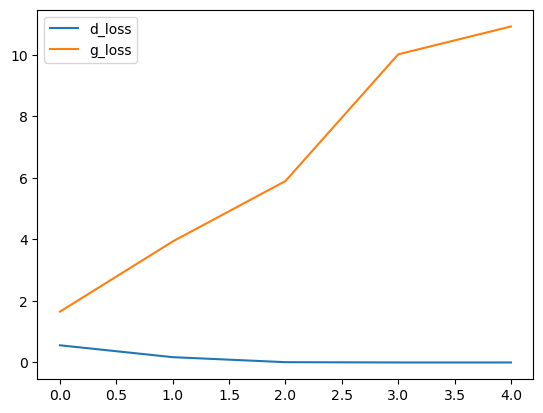

In [16]:
for key in hist.history:
    plt.plot(hist.history[key],label=key)
plt.legend()
plt.show()